In [1]:
import pandas as pd
import numpy as np
import spacy

from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

# Download the NLTK resources required for preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define the stop words to be removed
stop_words = set(stopwords.words('english'))

# Create an instance of the WordNetLemmatizer and PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Define a function to perform the preprocessing
def preprocess_text(text):
    # Convert everything to lowercase
    text = text.lower()

    # remove everything that is not an alphabet
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words]

    # Apply stemming
    words = [stemmer.stem(word) for word in words]

    # Join the words back into a string
    text = " ".join(words)

    return text

# Apply the preprocessing function to the 'text' column of the DataFrame 'df'
# df['article_claim_phase1'] = df['article_claim_phase1'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


<h1>Using the Kaggle2 (40k) Dataset<h1>

In [4]:
fake_data = pd.read_csv('/content/drive/MyDrive/HiTS/Datasets/Kaggle40K/Fake.csv')
true_data = pd.read_csv('/content/drive/MyDrive/HiTS/Datasets/Kaggle40K/True.csv')

In [6]:
fake_data.drop(['date'],axis=1,inplace=True)
true_data.drop(['date'],axis=1,inplace=True)

# labeling The dataset
fake_data['label'] = 0
true_data['label'] = 1

In [7]:
# Concatenate datasets
df2 = pd.concat([fake_data, true_data], ignore_index=True, sort=False)
df2.head()

,title,text,subject,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,0


In [8]:
df2.drop(['subject', 'text'], inplace=True, axis=1)

In [9]:
df2.head()

,title,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [10]:
df2.label.isna().sum()

0

In [11]:
df2.label.unique()

array([0, 1])

In [12]:
df2.isna().sum()

title    0
label    0
dtype: int64

In [13]:
df2 = df2.dropna()

In [14]:
df2.isna().sum()

title    0
label    0
dtype: int64

In [15]:
# During dropping of NaN values, some of the index is also removed so, reset index is necessary
df2.reset_index(inplace=True)

In [16]:
df2['title'] = df2['title'].apply(preprocess_text)
# filter out rows with length of string column equal to 0
df2 = df2[df2['title'].apply(lambda x: len(x.split(' ')) > 2)]

In [17]:
# During dropping of NaN values, some of the index is also removed so, reset index is necessary
df2.reset_index(inplace=True)

In [18]:
df2.head()

,level_0,index,title,label
0,0,0,donald trump send embarrass new year eve messa...,0
1,1,1,drunk brag trump staffer start russian collus ...,0
2,2,2,sheriff david clark becom internet joke threat...,0
3,3,3,trump obsess even obama name code websit imag,0
4,4,4,pope franci call donald trump christma speech,0


In [19]:
df2.shape

(44889, 4)

<h1>Spacy Word Embeddings<h1>

In [20]:
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [21]:
word_vectors = spacy.load('en_core_web_lg')

In [22]:
df2['vector'] = df2['title'].apply(lambda text: word_vectors(text).vector)  

In [23]:
df2.head()

,level_0,index,title,label,vector
0,0,0,donald trump send embarrass new year eve messa...,0,"[-0.3191433, 0.5317422, -1.3457077, 0.23608889..."
1,1,1,drunk brag trump staffer start russian collus ...,0,"[-0.79245245, 0.48412937, -1.2453126, 1.139591..."
2,2,2,sheriff david clark becom internet joke threat...,0,"[-0.31694397, 0.66029406, -0.86784697, 0.28814..."
3,3,3,trump obsess even obama name code websit imag,0,"[0.41400754, 1.4148113, 0.009950101, -0.571868..."
4,4,4,pope franci call donald trump christma speech,0,"[-0.65308714, -0.11899143, -0.46835136, 0.4770..."


In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df2.vector.values,
    df2.label,
    test_size=0.2,
    random_state=20
)

In [49]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [50]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

n_classes= np.unique(y_train)
# Define hyperparameters to search over
hyperparameters = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
          'fit_prior': [True, False],
          'class_prior': [None, [0.1,]* len(n_classes), ],
         }

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


clf = MultinomialNB()
grid_search = GridSearchCV(clf, hyperparameters, cv=5)
grid_search.fit(scaled_train_embed, y_train)
# clf.fit(scaled_train_embed, y_train)

# Get the best model
spacy_best_model = grid_search.best_estimator_

# Print best hyperparameters and corresponding accuracy
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)
print("Best model: ", spacy_best_model)

Best hyperparameters:  {'alpha': 0.01, 'class_prior': None, 'fit_prior': False}
Best accuracy:  0.7976384880713083
Best model:  MultinomialNB(alpha=0.01, fit_prior=False)


In [51]:
from sklearn.metrics import classification_report
y_pred = spacy_best_model.predict(scaled_test_embed)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.78      0.80      4664
           1       0.77      0.82      0.80      4314

    accuracy                           0.80      8978
   macro avg       0.80      0.80      0.80      8978
weighted avg       0.80      0.80      0.80      8978



Text(95.72222222222221, 0.5, 'Truth')

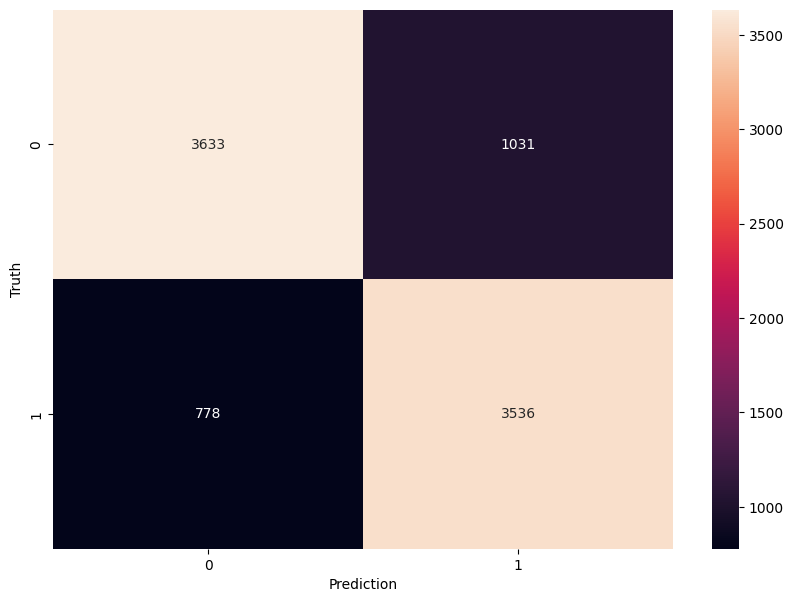

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

<h1>Gensim Word Embeddings<h1>

In [28]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [36]:
# Save the model to a file
model_file = "/content/drive/MyDrive/HiTS/Datasets/gensim_word2vec_model.bin"
wv.save(model_file)



# from gensim.models import KeyedVectors

# # Load the saved Word2Vec model from the file
# model_file = "/content/drive/MyDrive/HiTS/Datasets/gensim_word2vec_model.bin"
# wv = KeyedVectors.load(model_file, mmap='r')


In [30]:
def preprocess_and_vectorize(text):
    # remove stop words and lemmatize the text
    doc = word_vectors(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
        
    return wv.get_mean_vector(filtered_tokens)

In [31]:
df2['gensin_vector'] = df2['title'].apply(lambda text: preprocess_and_vectorize(text))

In [32]:
df2.head()

,level_0,index,title,label,vector,gensin_vector
0,0,0,donald trump send embarrass new year eve messa...,0,"[-0.3191433, 0.5317422, -1.3457077, 0.23608889...","[0.01622146, 0.043963913, 0.04809896, 0.013172..."
1,1,1,drunk brag trump staffer start russian collus ...,0,"[-0.79245245, 0.48412937, -1.2453126, 1.139591...","[-0.009183154, 0.0069779074, 0.008746688, 0.04..."
2,2,2,sheriff david clark becom internet joke threat...,0,"[-0.31694397, 0.66029406, -0.86784697, 0.28814...","[-0.00045894049, 0.0075058513, -0.010747313, 0..."
3,3,3,trump obsess even obama name code websit imag,0,"[0.41400754, 1.4148113, 0.009950101, -0.571868...","[-0.00755172, 0.0069641564, 0.022168554, 0.047..."
4,4,4,pope franci call donald trump christma speech,0,"[-0.65308714, -0.11899143, -0.46835136, 0.4770...","[0.05258698, 0.020252986, 0.017259084, 0.10421..."


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    df2.gensin_vector.values, 
    df2.label, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=20,
    stratify=df2.label
)

In [54]:
print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)


X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (35911,)
Shape of X_test before reshaping:  (8978,)
Shape of X_train after reshaping:  (35911, 300)
Shape of X_test after reshaping:  (8978, 300)


In [57]:
from sklearn.ensemble import GradientBoostingClassifier
# Using Random forest instead of gradient boosting to save time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#1. creating a GradientBoosting model object
# clf = GradientBoostingClassifier()
# clf = RandomForestClassifier()
# #2. fit with all_train_embeddings and y_train
# clf.fit(X_train_2d, y_train)


# #3. get the predictions for all_test_embeddings and store it in y_pred
# y_pred = clf.predict(X_test_2d)


# #4. print the classfication report
# print(classification_report(y_test, y_pred))


##########
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters to search over
# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [5, 7],
# }
param_grid = {
    'n_estimators': [50], #11 mins 5
    'max_depth': [5, 7, 10], #5 mins
    'min_samples_split': [2], #9 mins 2
    'min_samples_leaf': [2], #9 min 2
    'bootstrap': [False] #8 mins False
}

# Create a Random Forest classifier object
clf = RandomForestClassifier()

# Create a GridSearchCV object and fit it to the training data
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train_2d, y_train)

# Print the best set of hyperparameters found
print("Best hyperparameters: ", grid_search.best_params_)
gensim_best_model = grid_search.best_estimator_

# Use the best set of hyperparameters to make predictions on the test set
y_pred = gensim_best_model.predict(X_test_2d)

# Print the classification report
print(classification_report(y_test, y_pred))


Best hyperparameters:  {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4695
           1       0.88      0.88      0.88      4283

    accuracy                           0.89      8978
   macro avg       0.89      0.89      0.89      8978
weighted avg       0.89      0.89      0.89      8978



Text(95.72222222222221, 0.5, 'Truth')

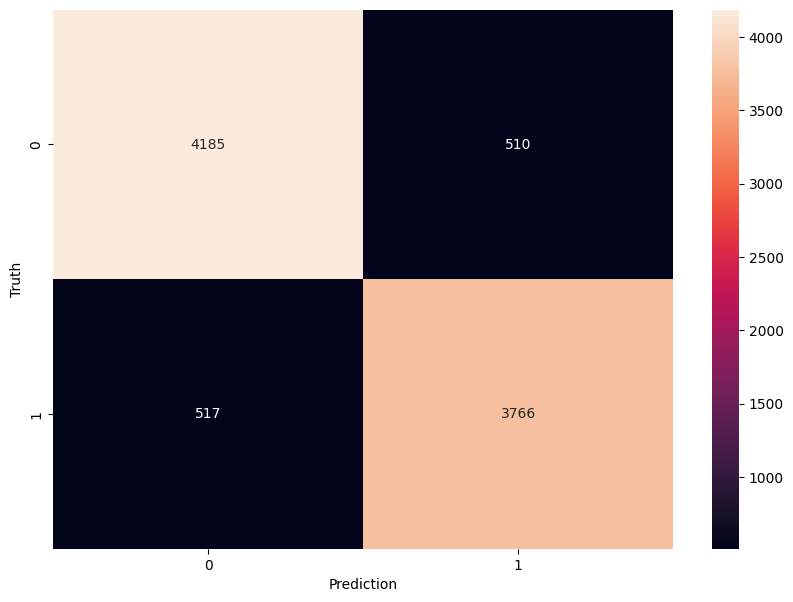

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

<h1>fasttext<h1>

In [ ]:
# import re

# def preprocess(text):
#     text = re.sub(r'[^\w\s\']',' ', text)
#     text = re.sub(' +', ' ', text)
#     return text.strip().lower() 

In [39]:
df2.head()

,level_0,index,title,label,vector,gensin_vector
0,0,0,donald trump send embarrass new year eve messa...,0,"[-0.3191433, 0.5317422, -1.3457077, 0.23608889...","[0.01622146, 0.043963913, 0.04809896, 0.013172..."
1,1,1,drunk brag trump staffer start russian collus ...,0,"[-0.79245245, 0.48412937, -1.2453126, 1.139591...","[-0.009183154, 0.0069779074, 0.008746688, 0.04..."
2,2,2,sheriff david clark becom internet joke threat...,0,"[-0.31694397, 0.66029406, -0.86784697, 0.28814...","[-0.00045894049, 0.0075058513, -0.010747313, 0..."
3,3,3,trump obsess even obama name code websit imag,0,"[0.41400754, 1.4148113, 0.009950101, -0.571868...","[-0.00755172, 0.0069641564, 0.022168554, 0.047..."
4,4,4,pope franci call donald trump christma speech,0,"[-0.65308714, -0.11899143, -0.46835136, 0.4770...","[0.05258698, 0.020252986, 0.017259084, 0.10421..."


In [40]:
df2['label1'] = '__label__' + df2['label'].apply(lambda text: str(text))  
df2['fasttext_input'] = df2['label1'] + ' ' + df2['title'] 

In [41]:
df2.head()
# df2.drop('fasttext_input', axis=1, inplace=True)

,level_0,index,title,label,vector,gensin_vector,label1,fasttext_input
0,0,0,donald trump send embarrass new year eve messa...,0,"[-0.3191433, 0.5317422, -1.3457077, 0.23608889...","[0.01622146, 0.043963913, 0.04809896, 0.013172...",__label__0,__label__0 donald trump send embarrass new yea...
1,1,1,drunk brag trump staffer start russian collus ...,0,"[-0.79245245, 0.48412937, -1.2453126, 1.139591...","[-0.009183154, 0.0069779074, 0.008746688, 0.04...",__label__0,__label__0 drunk brag trump staffer start russ...
2,2,2,sheriff david clark becom internet joke threat...,0,"[-0.31694397, 0.66029406, -0.86784697, 0.28814...","[-0.00045894049, 0.0075058513, -0.010747313, 0...",__label__0,__label__0 sheriff david clark becom internet ...
3,3,3,trump obsess even obama name code websit imag,0,"[0.41400754, 1.4148113, 0.009950101, -0.571868...","[-0.00755172, 0.0069641564, 0.022168554, 0.047...",__label__0,__label__0 trump obsess even obama name code w...
4,4,4,pope franci call donald trump christma speech,0,"[-0.65308714, -0.11899143, -0.46835136, 0.4770...","[0.05258698, 0.020252986, 0.017259084, 0.10421...",__label__0,__label__0 pope franci call donald trump chris...


In [42]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df2, test_size=0.2)



In [43]:
train.shape, test.shape

((35911, 8), (8978, 8))

In [44]:
train.to_csv("fasttext.train", columns=["fasttext_input"], index=False, header=False)
test.to_csv("fasttext.test", columns=["fasttext_input"], index=False, header=False)


In [46]:
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [45]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395612 sha256=35ddb3cfd2adeb2097518952c66e2bc53695f70454a22c56a4ac56c68eec76f6
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


In [47]:
import fasttext

model = fasttext.train_supervised(input="fasttext.train")
model.test("fasttext.test")

(8978, 0.9536645132546224, 0.9536645132546224)

In [ ]:
# model.predict("thunderstorm today")

(('__label__1',), array([1.00000942]))